# ECG Anomaly Detection using a Variational Auto Encoder <a class="anchor" id="start"></a>

**The dataset** : 
- 2000 normal heartbeats
- 2000 anomalous heartbeats unequally spread in 4 subtypes
    - R on T
    - PVC
    - SP
    - UB
    
**Goal** : Automatic recognition of anomalous heartbeat

**Approach** : Anomaly detection --> modeling normal heartbeat (thanks to a small dimensional latent space representation) and identifying anomalous one as the model should not fit them well/ they should be away from normal one in the latent space.
- Good approach when the anomaly are rare events (not the case here but my goal was to learn anomaly detection so from now on we will assume that **anomalous heartbeat are scarce in the dataset**)
- Agnostic to anomalous subtypes which can be good if they are very variable

**Alternative approach** : Not explored here 
- non stochastic Auto Encoder (if interested I have a notebook that compares all the different way to do auto encoder)
    - Easier : no need for deep probabilistic framework
    - Most of the code written here is reusable
- more straightforward classifier
    - Easier : no need for deep probabilistic framework
    - Most of the code written here is reusable
    - Need labelled data which is our case here even if for the exercise we ignore it

**Specifity** : ECG are temporal series so we are going to use Recurrent Neural Net and more precisely LSTM to capture the fact that there is an ordering of the points.

**Go to demonstration** : if you are not interested in the code, please just navigate to those parts

-[**overview**](#overview)

-[**Interesting results**](#Results)

## 2 words on the model



![AE](bigVAE.png)


Left part : encoder --> encode the sequence as a gaussian centered on z which is a point in the latent space representation. That z is generated thanks to a deep neural net given the ECG. In our case as an ECG is an ordered sequence of point the best kind of layer to use for our Deep Neural Net are of the recurrent type like LSTM layers

Right part : decoder


source : https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

Here in the loss function there is a trade off between the reconstruction loss which for a gaussian decoder is similar to the MSE and the KL divergence due to our encoder approximation matching to a normal distribution. The reconstruction loss is almost the MSE but scaled by the variance of the decoder and shifted by the log of that variance (A Tutorial on VAEs: From Bayes’ Rule to Lossless Compression : Ronald Yu).

Somehow the loss function in this image is missing the log variance shift introduced in     https://arxiv.org/pdf/2006.10273.pdf  

## Data gathering

In [1]:
from arff2pandas import a2p#you will need that for the reading of the ecg format file
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import copy

import torch#; torch.manual_seed(42)

import torch.nn.functional as F
import torch.utils
import torch.distributions

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from torch.distributions import constraints
import umap.umap_ as umap


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


with open('ECG5000/ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)
with open('ECG5000/ECG5000_TEST.arff') as f:
    test = a2p.load(f)
    
    
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns




#### Overview of the data<a class="anchor" id="overview"></a>

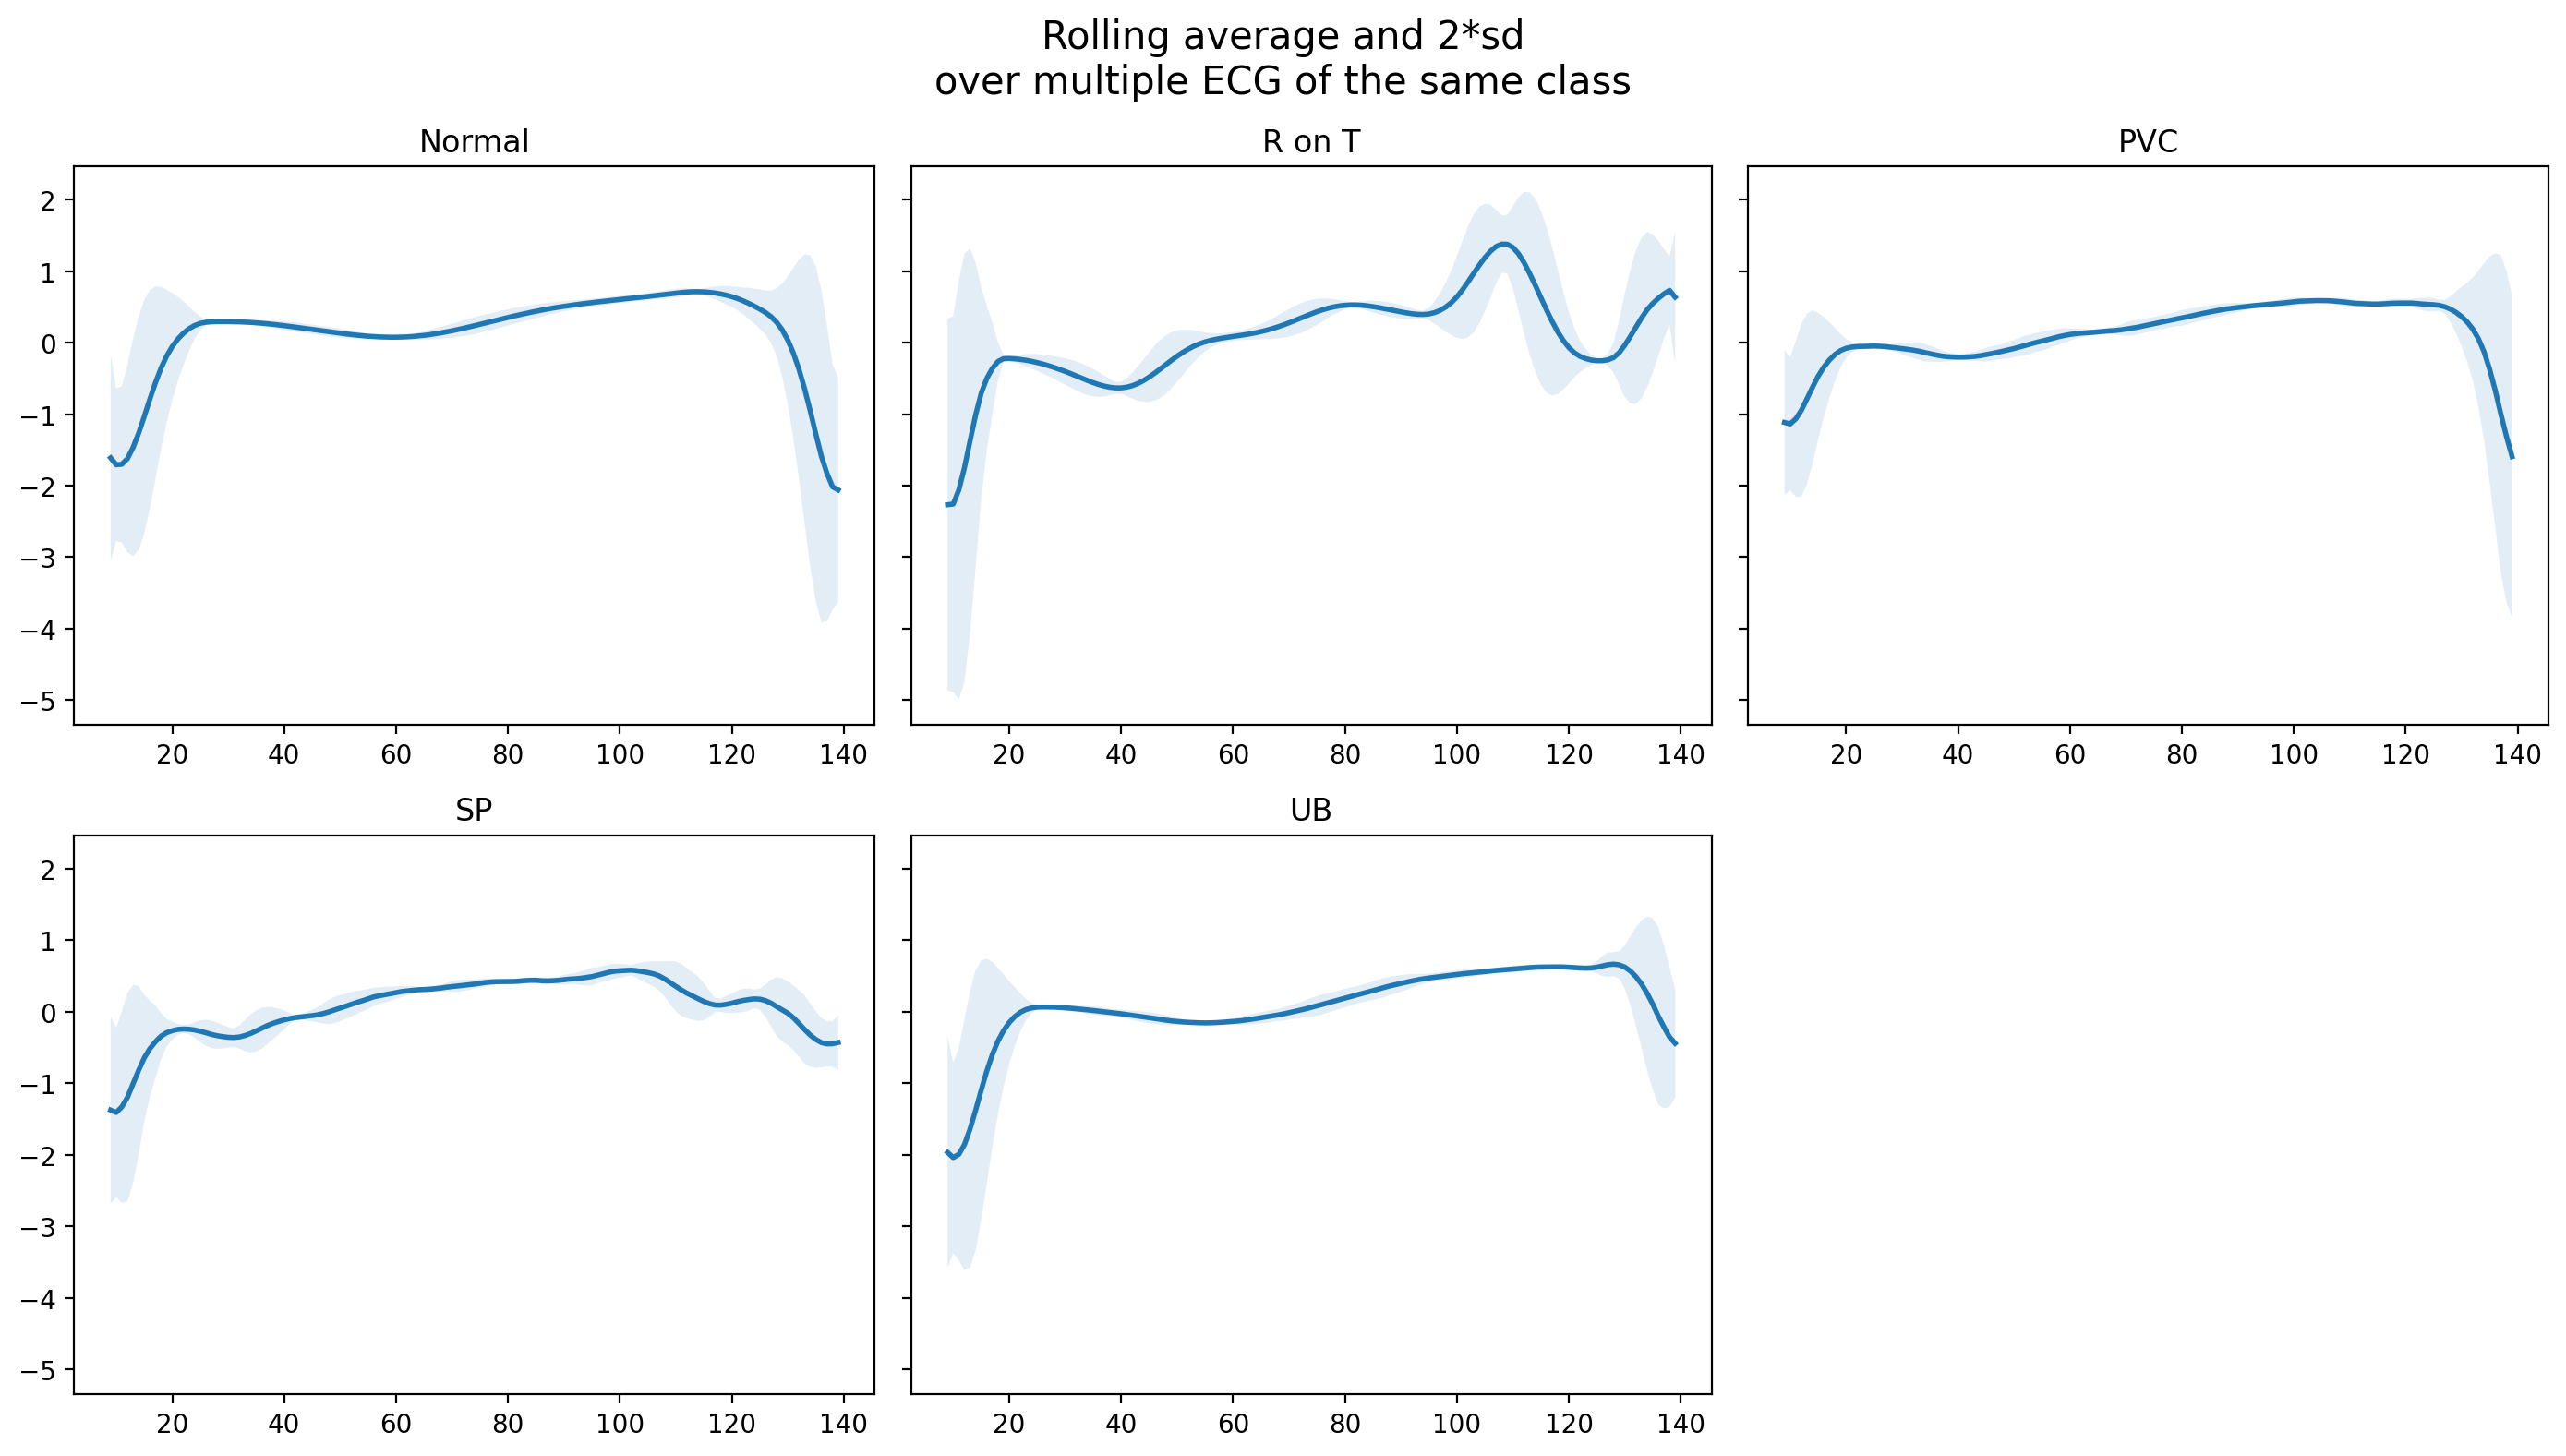

In [3]:
#this is 100% from  https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)
    
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.suptitle('Rolling average and 2*sd\nover multiple ECG of the same class',fontsize=15)
fig.tight_layout();

-[**begining**](#start)

-[**Interesting results**](#Results)

# Data preprocessing

Usual split of the data and definition of a useful dataloader

In [4]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)

In [5]:
normal_df.shape

(2919, 140)

In [6]:
anomaly_df.shape

(2081, 140)

In [7]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=42
)
val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=42
)

def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).numpy() for s in sequences]
    n_seq, seq_len, n_features = np.stack(dataset).shape
    return dataset, seq_len, n_features

train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)



In [8]:
df_good=pd.DataFrame(np.vstack([np.array(train_dataset).squeeze(),np.array(val_dataset).squeeze(),np.array(test_normal_dataset).squeeze(),np.array(test_anomaly_dataset).squeeze()]),columns=normal_df.columns)
df_good['anomalous']=[0 for i in range(len(normal_df))]+[1 for i in range(len(anomaly_df))]
df_good

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,anomalous
0,0.155694,-1.672682,-3.135914,-4.128550,-4.294534,-3.581789,-2.462764,-1.850276,-1.586431,-0.673669,...,1.353064,1.098911,0.870241,0.583669,0.517878,0.425843,0.249223,0.968535,-0.211107,0
1,-1.781558,-3.596960,-4.398259,-4.798338,-3.817334,-2.611595,-1.942173,-1.406053,-0.282480,-0.198064,...,1.194356,1.545750,1.762216,2.247523,2.325141,1.700578,0.752297,0.658723,-0.030236,0
2,0.965804,-0.564442,-2.061135,-3.735009,-4.291465,-3.649172,-2.460667,-1.854760,-1.665070,-0.831471,...,1.050924,0.857138,0.801706,0.769369,0.500943,0.642236,1.259584,1.684698,0.312416,0
3,-0.646473,-3.985438,-4.663767,-4.435896,-3.694867,-2.427538,-1.638079,-1.426744,-0.548428,-0.054210,...,1.374176,1.435412,1.377194,1.253091,0.877519,0.718943,0.704601,1.146158,-1.656649,0
4,0.406610,-2.008400,-3.973549,-4.361693,-3.831500,-3.180400,-2.175567,-1.648658,-1.425597,-0.625087,...,0.801793,1.268339,1.450844,1.409593,1.172675,1.278605,1.782985,1.559462,-0.586606,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.703059,0.397482,-0.189764,-0.605791,-0.788513,-1.033614,-1.096051,-0.876787,-0.564659,-0.414430,...,-0.308780,-0.686247,-1.092139,-2.007243,-3.048552,-3.988295,-5.151474,-5.650688,-5.594129,1
4996,-0.291451,-0.851884,-1.261694,-1.836120,-2.332473,-2.596231,-2.482354,-2.203106,-1.816012,-1.258853,...,-1.914752,-2.408895,-3.003351,-3.652317,-3.993051,-3.915856,-2.954840,-2.278642,-1.173630,1
4997,1.178418,0.025133,-1.102688,-2.121892,-3.028330,-3.350917,-3.160099,-2.716762,-2.159347,-1.539144,...,-2.156490,-2.680977,-3.220561,-3.313303,-2.676273,-1.658870,-0.483994,0.449598,0.890296,1
4998,0.886984,1.298134,1.219592,0.829978,0.022529,-0.616282,-0.938191,-1.364832,-1.721467,-1.723763,...,-1.688722,-2.008781,-2.506003,-3.030723,-3.474440,-4.013881,-4.484402,-4.181762,-3.073711,1


In [10]:
from torch.utils.data import Dataset
class ECG_dataset(Dataset):
    def __init__(self,sequences,targets):
        self.sequences=sequences
        self.targets=targets
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, item):
        sequence=self.sequences[item]
        target=int(self.targets[item])
        return {'sequence': torch.tensor(sequence, dtype=torch.float32),
                'target': torch.tensor(target, dtype=torch.long)
               }

In [11]:
_dataset, _, _ = create_dataset(df_good[list(df_good.columns)[:-1]])
godd_dataset = ECG_dataset(sequences=_dataset,targets=[0 for i in range(len(normal_df))]+[1 for i in range(len(anomaly_df))])

good_data_loader = torch.utils.data.DataLoader(godd_dataset,batch_size=128,num_workers=16)

In [12]:
i_train_dataset = ECG_dataset(sequences=train_dataset,targets=[0 for i in range(len(train_dataset))])

i_train_data_loader = torch.utils.data.DataLoader(i_train_dataset,batch_size=128,num_workers=16)

i_val_dataset = ECG_dataset(sequences=val_dataset,targets=[0 for i in range(len(val_dataset))])

i_val_data_loader = torch.utils.data.DataLoader(i_val_dataset,batch_size=128,num_workers=16)

In [13]:
df_n_a=pd.concat([normal_df,anomaly_df])
_dataset, _, _ = create_dataset(df_n_a)
i_dataset = ECG_dataset(sequences=_dataset,targets=[0 for i in range(len(normal_df))]+[1 for i in range(len(anomaly_df))])

i_data_loader = torch.utils.data.DataLoader(i_dataset,batch_size=128,num_workers=16)

In [14]:
df_n_a['anomalous']=[0 for i in range(len(normal_df))]+[1 for i in range(len(anomaly_df))]
df_n_a

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,anomalous
231,-1.065328,-4.210524,-4.842504,-4.476723,-3.407468,-2.221583,-1.539812,-1.377656,-0.464297,-0.179822,...,1.472254,1.421570,1.150938,1.034714,0.344639,-0.231766,-0.694628,0.144595,-0.188653,0
1241,-1.365439,-3.150865,-4.145265,-4.363822,-3.500689,-2.377694,-1.729924,-1.523937,-0.758443,-0.427105,...,1.284491,1.249346,1.433285,1.744923,1.687884,1.335939,1.092377,1.370740,1.052620,0
232,-0.109900,-1.878897,-2.993719,-4.071821,-3.963840,-3.134457,-1.960253,-1.542208,-1.451021,-0.693868,...,1.492484,1.070516,0.174598,-0.703928,-1.336386,-1.356925,-0.690676,0.365975,-0.723915,0
14,-2.012515,-3.844162,-4.090216,-4.121165,-3.673671,-2.735131,-1.616463,-1.438019,-1.094038,-0.647775,...,1.190223,1.330603,1.297486,1.264153,1.131445,1.212208,1.239823,1.139361,-0.618261,0
1189,-1.261477,-3.558816,-4.074347,-4.127428,-3.670285,-2.929925,-1.605859,-0.978395,-0.738122,-0.124714,...,1.065147,0.877131,0.644057,0.517045,0.571512,0.821328,-0.473388,-2.488627,-4.306003,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4050,0.703059,0.397482,-0.189764,-0.605791,-0.788513,-1.033614,-1.096051,-0.876787,-0.564659,-0.414430,...,-0.308780,-0.686247,-1.092139,-2.007243,-3.048552,-3.988295,-5.151474,-5.650688,-5.594128,1
3755,-0.291451,-0.851884,-1.261694,-1.836120,-2.332473,-2.596231,-2.482354,-2.203107,-1.816012,-1.258853,...,-1.914752,-2.408895,-3.003351,-3.652317,-3.993051,-3.915856,-2.954840,-2.278642,-1.173630,1
3519,1.178418,0.025133,-1.102688,-2.121892,-3.028329,-3.350917,-3.160099,-2.716762,-2.159347,-1.539144,...,-2.156490,-2.680977,-3.220561,-3.313303,-2.676273,-1.658870,-0.483994,0.449598,0.890296,1
4317,0.886984,1.298134,1.219592,0.829978,0.022529,-0.616282,-0.938191,-1.364832,-1.721467,-1.723763,...,-1.688722,-2.008781,-2.506003,-3.030723,-3.474440,-4.013881,-4.484402,-4.181762,-3.073711,1


# Pyro VAE

Model written in Pyro.ai

In [15]:
class EncoderPyroVAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(EncoderPyroVAE, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn3 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x1, (hidden_n_mu, _) = self.rnn2(x)
        x2, (hidden_n_sigma, _) = self.rnn3(x)

        z_loc=hidden_n_mu.permute(1,0,2)
        z_scale=torch.exp(hidden_n_sigma.permute(1,0,2))
        
        
        return z_loc.squeeze(),z_scale.squeeze()#I need to squeeze to get rid to the extra dimension of my data.
    #This extra dimension is linked to how our x is defined : each point in x has a single feature. This
    #dimension is dragued till this end but pyro doesn't get it so I had to squeeze.
    
    
    
class DecoderPyroVAE(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(DecoderPyroVAE, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        x = torch.stack([x1.repeat(self.seq_len, self.n_features)for x1 in x])
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = self.output_layer(x)
        return x

    


        
class PyroVAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64,use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = EncoderPyroVAE(seq_len, n_features, embedding_dim)
        self.decoder = DecoderPyroVAE(seq_len, embedding_dim, n_features)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = embedding_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        #sigma = pyro.sample("sigma",dist.HalfCauchy(0.1))
        sigma = pyro.param("sigma", torch.tensor([0.4]), constraint=constraints.positive)
        # we are going to fit our data with a normal distribution (very approximate here...)
        #(see that as the maxlieklihood part of our loss : before we were using L1 or L2 now
        # since we are using distribution we use maxlikelihood)
        # that will be centered around the output of our decoder on a specific region of the latent space
        # that will be sampled according of the encoder results... The sigma of that normal distribution
        # if found to maximize likelihood
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0],self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0],self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_ecg = self.decoder(z)
            
            # score against actual ecg (log likelihood)
            pyro.sample("obs", dist.Normal(loc_ecg.squeeze(),sigma.to(device)).to_event(1), obs=x.squeeze())


    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    # we will need a reconstruct to actually check how our algo generalize
    # Indeed we can not evaluate the ELBO loss on a validation test.... SO we are going to use L1 or 2
    def reconstruct_ecg(self, x):
        # encode ecg x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the ecg
        loc_ecg = self.decoder(z)
        return loc_ecg
    def reconstruct_ecg_from_pairs(self, x,rep,interval):
        # encode ecg x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        
        
        delta_z_loc=(z_loc[1]-z_loc[0])/interval
        delta_z_scale=(z_scale[1]-z_scale[0])/interval
        keep_loc_ecg=[]
        keep_zloc=[z_loc[0]]
        zloc0=z_loc[0]
        zscale0=z_scale[0]
        zloc0_=torch.clone(zloc0)
        zscale0_=torch.clone(zscale0)
        for t in range(interval):
            ze=[]
            for g in range(rep):
                ze.append(dist.Normal(zloc0_, zscale0_).sample())
            zloc0_=(t+1)*delta_z_loc+zloc0
            zscale0_=(t+1)*delta_z_scale+zscale0
            keep_zloc.append(zloc0_)
            keep_loc_ecg.append(self.decoder(torch.vstack(ze)))
        ze=[]
        for g in range(rep):
            ze.append(dist.Normal(zloc0_, zscale0_).sample())
        keep_loc_ecg.append(self.decoder(torch.vstack(ze)))
        
        return keep_loc_ecg,keep_zloc
    
def train_pyroVAE_better(svi, model,train_loader,val_loader, use_cuda=False):
    # initialize loss accumulator
    criterion = nn.L1Loss(reduction='mean').to(device)#Check L2
    #criterion = nn.MSELoss(reduction='mean').to(device)
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for d in train_loader:
        # if on GPU put mini-batch into CUDA memory
        x=d['sequence']
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
    val_losses = []
    train_losses = []
    #not sure you need any of those eval and torch.no_grad(). Let's check the l1 loss for our training and eval
    model = model.eval()
    with torch.no_grad():
        for d in train_loader:
            seq_true=d['sequence']
            seq_true = seq_true.to(device)
            seq_pred = model.reconstruct_ecg(seq_true)
            loss = criterion(seq_pred, seq_true)
            train_losses.append(loss.item())
        for d in val_loader:
            seq_true=d['sequence']
            seq_true = seq_true.to(device)
            seq_pred = model.reconstruct_ecg(seq_true)
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train,train_loss,val_loss

#### Actual training (don't run if not necessary)

In [33]:
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 500


pyro.clear_param_store()

# setup the VAE
pyrovae = PyroVAE(seq_len, n_features, 14,use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(pyrovae.model, pyrovae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
val_l1_list = []
train_l1_list = []
pyro.clear_param_store()
# training loop, sorry there might be a bit of miss labelling between L1 and L2 loss
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train,train_l1,val_l1 = train_pyroVAE_better(svi, pyrovae,i_train_data_loader,i_val_data_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    train_l1_list.append(train_l1)
    val_l1_list.append(val_l1)
    print("[epoch %03d]  average training ELBO loss: %.4f, average training l1 loss: %.4f average val loss: %.4f" % (epoch, total_epoch_loss_train,train_l1,val_l1))

/home/seb/anaconda3/envs/base_py39/lib/python3.9/site-packages/torch/backends/cudnn/__init__.py:73: UserWarning: PyTorch was compiled without cuDNN/MIOpen support. To use cuDNN/MIOpen, rebuild PyTorch making sure the library is visible to the build system.
  warnings.warn(


[epoch 000]  average training ELBO loss: 426.1561, average training l1 loss: 0.6655 average val loss: 0.6680
[epoch 001]  average training ELBO loss: 398.7307, average training l1 loss: 0.6420 average val loss: 0.6453
[epoch 002]  average training ELBO loss: 324.8614, average training l1 loss: 0.5456 average val loss: 0.5499
[epoch 003]  average training ELBO loss: 267.4779, average training l1 loss: 0.5381 average val loss: 0.5456
[epoch 004]  average training ELBO loss: 243.1232, average training l1 loss: 0.5125 average val loss: 0.5225
[epoch 005]  average training ELBO loss: 223.5511, average training l1 loss: 0.4982 average val loss: 0.5064
[epoch 006]  average training ELBO loss: 206.1336, average training l1 loss: 0.4806 average val loss: 0.4860
[epoch 007]  average training ELBO loss: 189.6361, average training l1 loss: 0.4692 average val loss: 0.4756
[epoch 008]  average training ELBO loss: 176.2466, average training l1 loss: 0.4534 average val loss: 0.4599
[epoch 009]  averag

[epoch 076]  average training ELBO loss: 74.0367, average training l1 loss: 0.2455 average val loss: 0.2406
[epoch 077]  average training ELBO loss: 72.9883, average training l1 loss: 0.2452 average val loss: 0.2459
[epoch 078]  average training ELBO loss: 73.0136, average training l1 loss: 0.2461 average val loss: 0.2450
[epoch 079]  average training ELBO loss: 71.6257, average training l1 loss: 0.2430 average val loss: 0.2427
[epoch 080]  average training ELBO loss: 70.9297, average training l1 loss: 0.2489 average val loss: 0.2505
[epoch 081]  average training ELBO loss: 73.1283, average training l1 loss: 0.2484 average val loss: 0.2441
[epoch 082]  average training ELBO loss: 69.8976, average training l1 loss: 0.2421 average val loss: 0.2406
[epoch 083]  average training ELBO loss: 70.0624, average training l1 loss: 0.2479 average val loss: 0.2483
[epoch 084]  average training ELBO loss: 71.2210, average training l1 loss: 0.2399 average val loss: 0.2395
[epoch 085]  average trainin

[epoch 152]  average training ELBO loss: 50.2055, average training l1 loss: 0.2075 average val loss: 0.2081
[epoch 153]  average training ELBO loss: 49.1932, average training l1 loss: 0.2041 average val loss: 0.2034
[epoch 154]  average training ELBO loss: 48.1755, average training l1 loss: 0.2017 average val loss: 0.1999
[epoch 155]  average training ELBO loss: 47.9715, average training l1 loss: 0.2105 average val loss: 0.2127
[epoch 156]  average training ELBO loss: 47.4584, average training l1 loss: 0.2106 average val loss: 0.2106
[epoch 157]  average training ELBO loss: 46.8867, average training l1 loss: 0.2024 average val loss: 0.2014
[epoch 158]  average training ELBO loss: 46.2484, average training l1 loss: 0.1966 average val loss: 0.1969
[epoch 159]  average training ELBO loss: 45.3855, average training l1 loss: 0.1967 average val loss: 0.1977
[epoch 160]  average training ELBO loss: 45.8370, average training l1 loss: 0.1959 average val loss: 0.1962
[epoch 161]  average trainin

[epoch 228]  average training ELBO loss: 48.1368, average training l1 loss: 0.1899 average val loss: 0.1921
[epoch 229]  average training ELBO loss: 38.5505, average training l1 loss: 0.1863 average val loss: 0.1869
[epoch 230]  average training ELBO loss: 38.8603, average training l1 loss: 0.1864 average val loss: 0.1890
[epoch 231]  average training ELBO loss: 38.7161, average training l1 loss: 0.1833 average val loss: 0.1893
[epoch 232]  average training ELBO loss: 37.9156, average training l1 loss: 0.1855 average val loss: 0.1899
[epoch 233]  average training ELBO loss: 38.3982, average training l1 loss: 0.1855 average val loss: 0.1874
[epoch 234]  average training ELBO loss: 39.9801, average training l1 loss: 0.1876 average val loss: 0.1947
[epoch 235]  average training ELBO loss: 39.5165, average training l1 loss: 0.1823 average val loss: 0.1875
[epoch 236]  average training ELBO loss: 36.8931, average training l1 loss: 0.1860 average val loss: 0.1886
[epoch 237]  average trainin

[epoch 304]  average training ELBO loss: 31.5827, average training l1 loss: 0.1803 average val loss: 0.1829
[epoch 305]  average training ELBO loss: 35.0903, average training l1 loss: 0.1793 average val loss: 0.1823
[epoch 306]  average training ELBO loss: 30.3923, average training l1 loss: 0.1753 average val loss: 0.1767
[epoch 307]  average training ELBO loss: 29.9143, average training l1 loss: 0.1765 average val loss: 0.1792
[epoch 308]  average training ELBO loss: 29.6497, average training l1 loss: 0.1773 average val loss: 0.1752
[epoch 309]  average training ELBO loss: 28.8657, average training l1 loss: 0.1759 average val loss: 0.1798
[epoch 310]  average training ELBO loss: 30.6652, average training l1 loss: 0.1764 average val loss: 0.1815
[epoch 311]  average training ELBO loss: 29.9157, average training l1 loss: 0.1792 average val loss: 0.1816
[epoch 312]  average training ELBO loss: 32.5362, average training l1 loss: 0.1777 average val loss: 0.1825
[epoch 313]  average trainin

[epoch 380]  average training ELBO loss: 35.0789, average training l1 loss: 0.1825 average val loss: 0.1904
[epoch 381]  average training ELBO loss: 29.9938, average training l1 loss: 0.1703 average val loss: 0.1761
[epoch 382]  average training ELBO loss: 25.9458, average training l1 loss: 0.1695 average val loss: 0.1735
[epoch 383]  average training ELBO loss: 22.6517, average training l1 loss: 0.1685 average val loss: 0.1739
[epoch 384]  average training ELBO loss: 21.7125, average training l1 loss: 0.1676 average val loss: 0.1722
[epoch 385]  average training ELBO loss: 21.7293, average training l1 loss: 0.1683 average val loss: 0.1736
[epoch 386]  average training ELBO loss: 22.5859, average training l1 loss: 0.1842 average val loss: 0.1879
[epoch 387]  average training ELBO loss: 32.6251, average training l1 loss: 0.1974 average val loss: 0.2009
[epoch 388]  average training ELBO loss: 31.8625, average training l1 loss: 0.1709 average val loss: 0.1740
[epoch 389]  average trainin

[epoch 456]  average training ELBO loss: 21.6345, average training l1 loss: 0.1732 average val loss: 0.1797
[epoch 457]  average training ELBO loss: 26.2253, average training l1 loss: 0.1890 average val loss: 0.1956
[epoch 458]  average training ELBO loss: 27.4172, average training l1 loss: 0.1672 average val loss: 0.1720
[epoch 459]  average training ELBO loss: 17.6995, average training l1 loss: 0.1616 average val loss: 0.1679
[epoch 460]  average training ELBO loss: 16.1729, average training l1 loss: 0.1620 average val loss: 0.1699
[epoch 461]  average training ELBO loss: 15.0681, average training l1 loss: 0.1633 average val loss: 0.1686
[epoch 462]  average training ELBO loss: 15.8058, average training l1 loss: 0.1610 average val loss: 0.1685
[epoch 463]  average training ELBO loss: 16.0333, average training l1 loss: 0.1616 average val loss: 0.1711
[epoch 464]  average training ELBO loss: 16.1215, average training l1 loss: 0.1634 average val loss: 0.1692
[epoch 465]  average trainin

In [34]:
MODEL_PATH = '/home/seb/Documents/Work/HSAM/exo/model_pyrovae_ECG_sigma_param_epochs_500_latentdim_14.pth'
torch.save(pyrovae.state_dict(), MODEL_PATH)



In [16]:
MODEL_PATH = '/home/seb/Documents/Work/HSAM/exo/model_pyrovae_ECG_sigma_param_epochs_500_latentdim_14.pth'

USE_CUDA = True
pyrovae=PyroVAE(seq_len, n_features, 14,use_cuda=USE_CUDA)
pyrovae.load_state_dict(torch.load(MODEL_PATH))

/home/seb/anaconda3/envs/base_py39/lib/python3.9/site-packages/torch/backends/cudnn/__init__.py:73: UserWarning: PyTorch was compiled without cuDNN/MIOpen support. To use cuDNN/MIOpen, rebuild PyTorch making sure the library is visible to the build system.
  warnings.warn(


<All keys matched successfully>

# Plotting code

A few definitons for making interesting plot

In [17]:
def basic_umap(data,nei,i):
    
    X=np.array(data)
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    umaper.fit(X[:i,:-1])
    x_umap = umaper.transform(X[:,:-1])
    sc=plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=X[:,-1], cmap='RdBu')
    cb = plt.colorbar(sc,ticks=np.arange(0,2,1))
    cb.ax.tick_params(labelsize=9)
    cb.ax.set_yticklabels(['Normal','Abnormal'])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP initial space')
    plt.show()

In [18]:
def plot_latent_pyro_vea(autoencoder, data,nei):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['sequence']
        y=d['target'].to('cpu').detach().numpy().tolist()
        kee=[]
        for k in range(100):
            z,sigma = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            kee.append([r for r in z])
        kee=np.array(kee)
        z = kee.mean(axis=0).tolist()
        stack.extend([x for x in z])
        stacky.extend(y)
    
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    x_umap = umaper.fit_transform(stack)
    sc=plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='RdBu')
    cb = plt.colorbar(sc,ticks=np.arange(0,2,1))
    cb.ax.tick_params(labelsize=9)
    cb.ax.set_yticklabels(['Normal','Abnormal'])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP latent space')
    plt.show()
    

In [19]:
def plot_latent_pyro_vea_pair(autoencoder, data,nei,pair,dat,rep,interval,dim):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['sequence']
        y=d['target'].to('cpu').detach().numpy().tolist()
        kee=[]
        for k in range(rep):
            z,sigma = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            kee.append([r for r in z])
        kee=np.array(kee)
        z = kee.mean(axis=0).tolist()
        stack.extend([x for x in z])
        stacky.extend(y)
    
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    
    _,zs=pyrovae.reconstruct_ecg_from_pairs( torch.tensor([dat[pair[0]],dat[pair[1]]]).to(device),rep,interval)
    umaper.fit(stack+[kk for kk in torch.cat(zs[1:-1]).detach().to('cpu').numpy().reshape(interval-1,dim)])
    x_umap = umaper.transform(stack)
    zs_umap=umaper.transform(torch.cat(zs[1:-1]).detach().to('cpu').numpy().reshape(interval-1,dim))
    sc=plt.scatter([x_umap[f, 0] for f in pair], [x_umap[f, 1] for f in pair],s=20, c=[stacky[f] for f in pair], cmap='RdBu')
    plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='RdBu',alpha=0.1)
    plt.scatter(zs_umap[:, 0], zs_umap[:, 1],s=20, c='k', marker='*')
    cb = plt.colorbar(sc,ticks=np.arange(0,2,1))
    cb.ax.tick_params(labelsize=9)
    cb.ax.set_yticklabels(['Normal','Abnormal'])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP latent space\nchosen pair')
    plt.show()
    

In [20]:
def ecg_pred(rec,rep,i):
    ecg_sample=np.array([np.array(rec)[k].reshape(128,140,1)[i] for k in range(rep)])
    ecg_std=ecg_sample.std(axis=0)
    ecg_mean=ecg_sample.mean(axis=0)
    zeros_5=torch.tensor(ecg_sample).kthvalue(int(len(ecg_sample) * 0.05), dim=0)[0]
    zeros_95=torch.tensor(ecg_sample).kthvalue(int(len(ecg_sample) * 0.95), dim=0)[0]
    plt.plot(np.arange(140),ecg_mean,'k',label='mean predict')
    plt.plot(np.arange(140),train_dataset[i].flatten(),'r',label='ground truth')
    plt.fill_between(np.arange(140),
                   [s[0] for s in zeros_5],
                   [s[0] for s in zeros_95],color='orange',
                   alpha=0.9,label='90% CI')
    plt.fill_between(np.arange(140),
                   [m[0]-s[0] for m,s in zip(ecg_mean,ecg_std)],
                   [m[0]+s[0] for m,s in zip(ecg_mean,ecg_std)],
                   alpha=0.5,color='blue',label='std predict')
    
    plt.legend(loc='best',fontsize=10)
    plt.xlabel('t')
    
    plt.show()

In [21]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [22]:
def ecg_pred_single(dat,rep,i):
    
    rec=pyrovae.reconstruct_ecg(torch.tensor([dat[i] for k in range(rep)]).to(device)).detach().to('cpu').numpy()
    ecg_sample=np.array(rec)
    print(ecg_sample.shape)
    ecg_std=ecg_sample.std(axis=0)
    ecg_mean=ecg_sample.mean(axis=0)
    zeros_5=torch.tensor(ecg_sample).kthvalue(int(len(ecg_sample) * 0.05), dim=0)[0]
    zeros_95=torch.tensor(ecg_sample).kthvalue(int(len(ecg_sample) * 0.95), dim=0)[0]
    plt.plot(np.arange(140),ecg_mean,'k',label='mean predict')
    plt.plot(np.arange(140),dat[i].flatten(),'r',label='ground truth')
    plt.fill_between(np.arange(140),
                   [s[0] for s in zeros_5],
                   [s[0] for s in zeros_95],color='orange',
                   alpha=0.9,label='90% CI')
    plt.fill_between(np.arange(140),
                   [m[0]-s[0] for m,s in zip(ecg_mean,ecg_std)],
                   [m[0]+s[0] for m,s in zip(ecg_mean,ecg_std)],
                   alpha=0.5,color='blue',label='std predict')
    
    plt.legend(loc='best',fontsize=10)
    plt.xlabel('t')
    plt.title('ECG number {} in {}'.format(i,namestr(dat, globals())[0]))
    
    plt.show()

In [23]:
def pyroVAE_loss(model=pyrovae,loader=i_data_loader, use_cuda=False):
    criterion = nn.L1Loss(reduction='mean').to(device)
    model = model.eval()
    losses={}
    k=0
    with torch.no_grad():
        for d in loader:
            seq_true=d['sequence']
            target_true=d['target']
            seq_true = seq_true.to(device)
            seq_pred = model.reconstruct_ecg(seq_true)
            for p,t,tar in zip(seq_pred, seq_true,target_true):
                loss = criterion(p, t)
            
                losses[k]=[loss.item(),tar.item()]
                k+=1
        
    return losses

In [24]:
def loss_plot(loss_train,loss_val):
    fig=plt.figure(figsize=(5,5))
    plt.plot(np.arange(len(loss_train)),loss_train,'b',label='train')
    plt.plot(np.arange(len(loss_val)),loss_val,'r',label='val')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('L1 loss')
    #plt.ylabel('MSE loss')
    plt.show()

In [25]:
def generating_intermediates(dat,rep,i,interval,seq_len=140,n_f=1):
    rr,_=pyrovae.reconstruct_ecg_from_pairs( torch.tensor([dat[i[0]],dat[i[1]]]).to(device),rep,interval)
    rr_array=torch.cat(rr).detach().to('cpu').numpy().reshape(interval+1,rep,seq_len,n_f)
    ecg_std=rr_array.std(axis=1)
    ecg_mean=rr_array.mean(axis=1)
    fig,ax=plt.subplots(int(np.ceil(float((interval+1)/3))),3,'all')
    for k in range(ecg_mean.shape[0]):
        
        zeros_5=torch.tensor(rr_array[k]).kthvalue(int(len(rr_array[k]) * 0.05), dim=0)[0]
        zeros_95=torch.tensor(rr_array[k]).kthvalue(int(len(rr_array[k]) * 0.95), dim=0)[0]
        ax[int(float(k/3)),k%3].plot(np.arange(seq_len),ecg_mean[k],'k',label='mean predict')
        ax[int(float(k/3)),k%3].fill_between(np.arange(seq_len),
                       [s[0] for s in zeros_5],
                       [s[0] for s in zeros_95],color='orange',
                       alpha=0.9,label='90% CI')
        ax[int(float(k/3)),k%3].fill_between(np.arange(seq_len),
                       [m[0]-s[0] for m,s in zip(ecg_mean[k],ecg_std[k])],
                       [m[0]+s[0] for m,s in zip(ecg_mean[k],ecg_std[k])],
                       alpha=0.5,color='blue',label='std predict')

        
        
        if k==0:
            ax[int(float(k/3)),k%3].plot(np.arange(seq_len),dat[i[0]].flatten(),'r',label='ground truth')
        if k==interval:
            ax[int(float(k/3)),k%3].plot(np.arange(seq_len),dat[i[1]].flatten(),'r',label='ground truth')
        ax[int(float(k/3)),k%3].legend(loc='best',fontsize=3)
    plt.tight_layout()
    plt.show()

# Plotting <a class="anchor" id="Results"></a>

Our latent space if of dimension 14 which is a 10 fold reduction in dimensionality. For visualization we will use UMAP 2D.

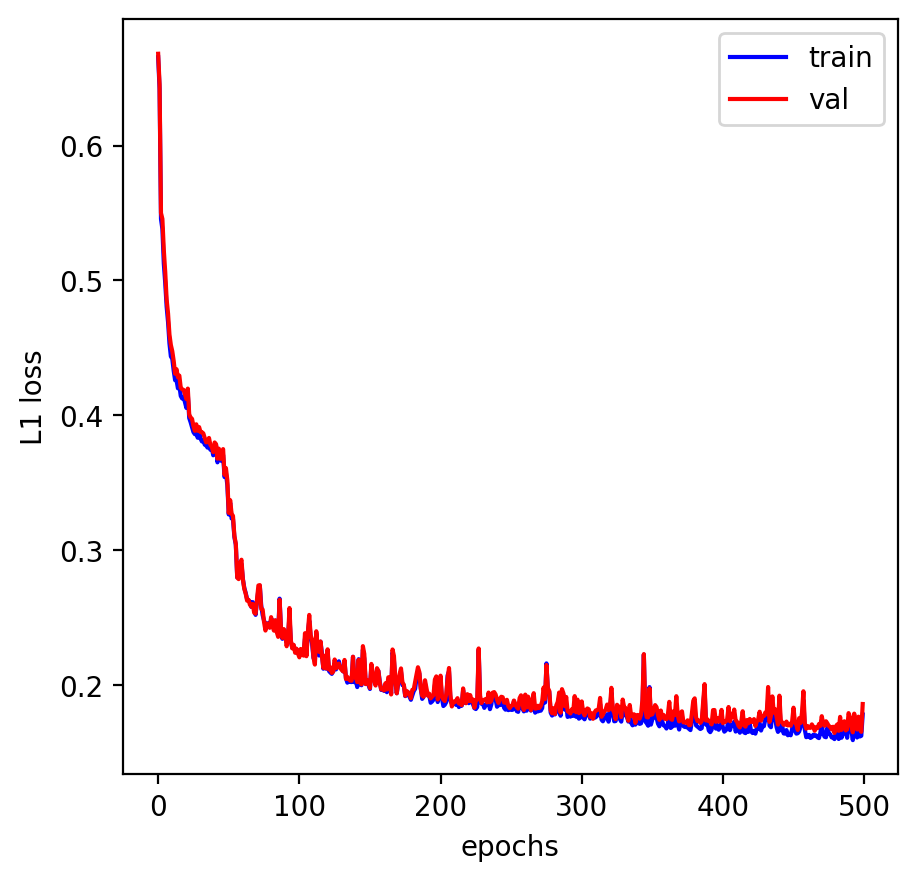

In [40]:
loss_plot(train_l1_list,val_l1_list)

Each point is a complete ECG represented in the UMAP space. The UMAP space trained on normal doesn't do a good job in separating normal to anomalous heartbeat. Even if it was doing a good job, For me the problem here is that I am not confident to work in the UMAP space for clustering or classifying. SO I would rather not and work in the learned latent space instead.

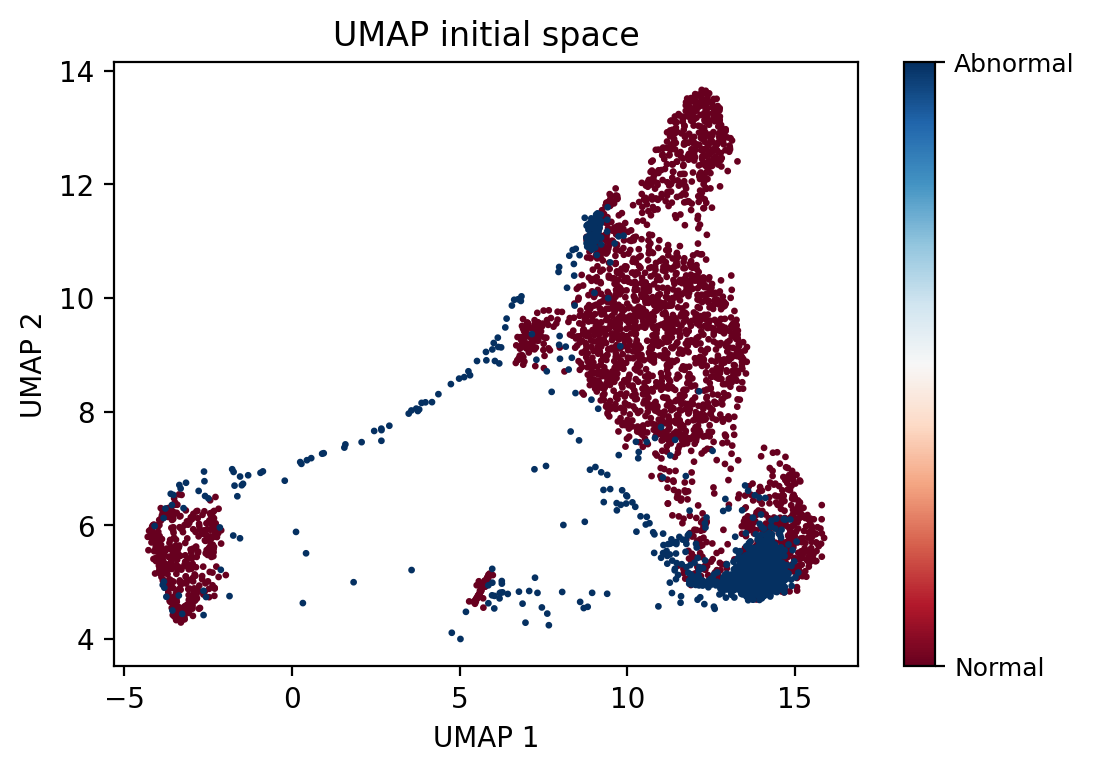

In [41]:
basic_umap(df_n_a,100,normal_df.shape[0])

If we were training the UMAP on both normal and anomalous together. We have a good separation with UMAP only. First of all that is not fair, second if we are in the scenario where we only have a few anomalous then this is not feasible, finally the representation change drastically so I really don't want to work in that space even if some says that it is possible....

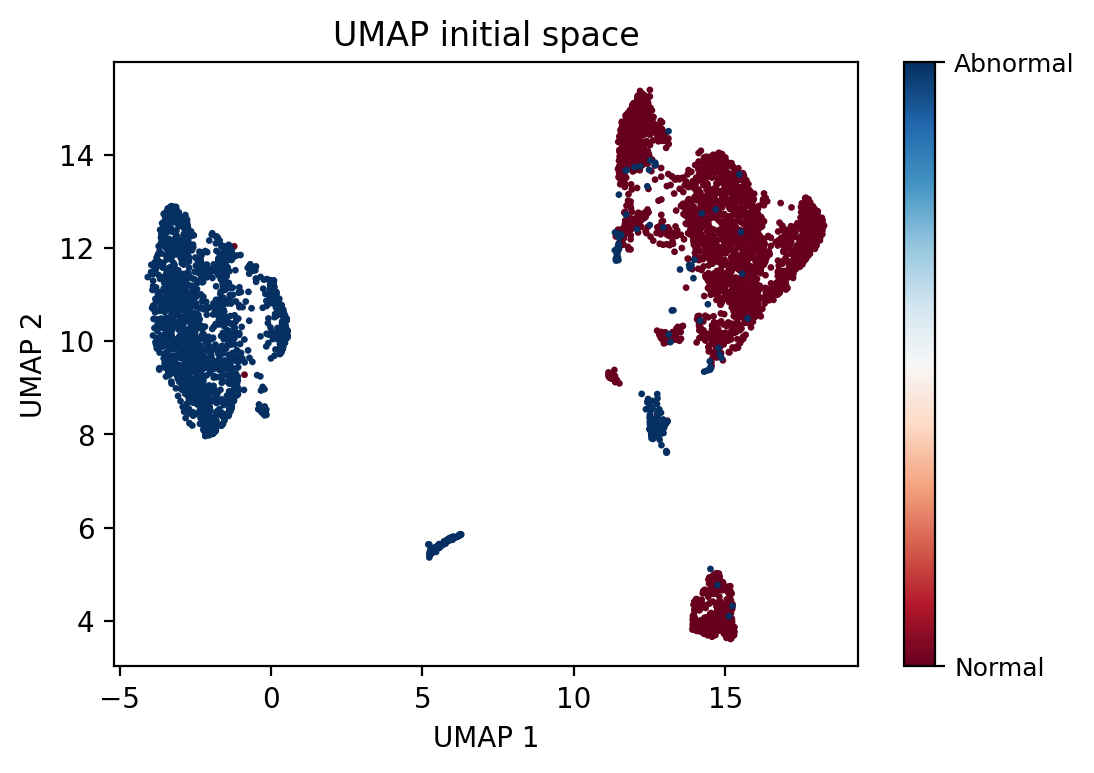

In [27]:
basic_umap(df_n_a,100,df_n_a.shape[0])

 Finally here, each point is a complete ECG represented in the small dimensional latent space : abnormal ECG (which have never been seen in the training) are represented far away from normal ECG --> in that space calssifying becomes easy!

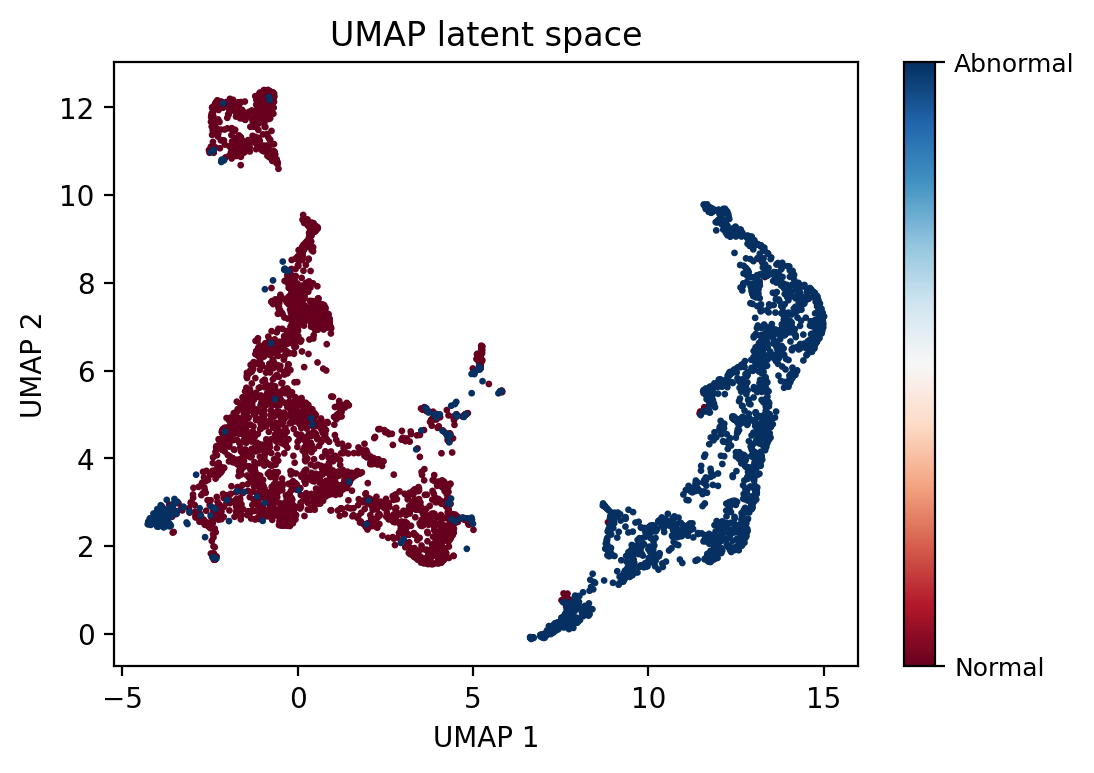

In [42]:
plot_latent_pyro_vea(pyrovae, i_data_loader,100)

The cool thing with generative model like auto encoder is that you can actually check what the model sees. Since it is stochastic variational you also have access to confidence interval : you can actually see where the model is sure or not about it's output. I think we can use that as a negative fingerprint of interesting features that really differentiate normal to anomalous data point (see below and last cells)

##### Normal reconstruction

Our model can easily reconstruct normal known hearbeat from that latent space representation but can also generate new heartbeat that would be considered normal or anomalous according to where you sample in the latent space.

Moreover as the model is probabilistic we can estimate confidence interval around our modelization of a heartbeat.

(100, 140, 1)


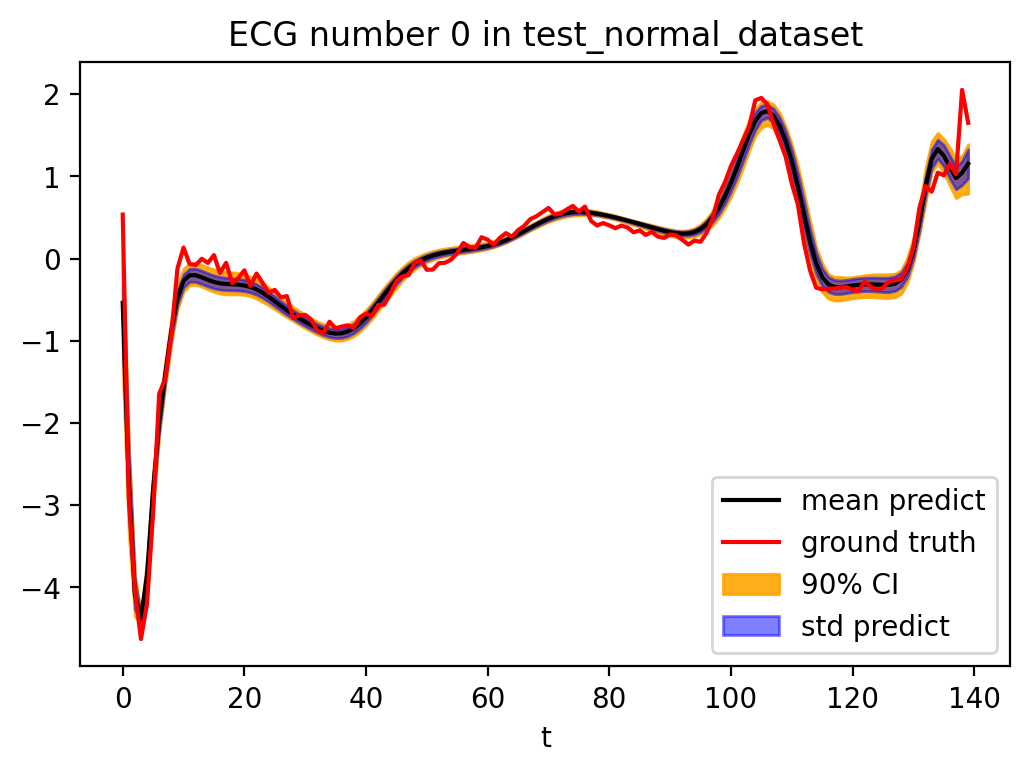

(100, 140, 1)


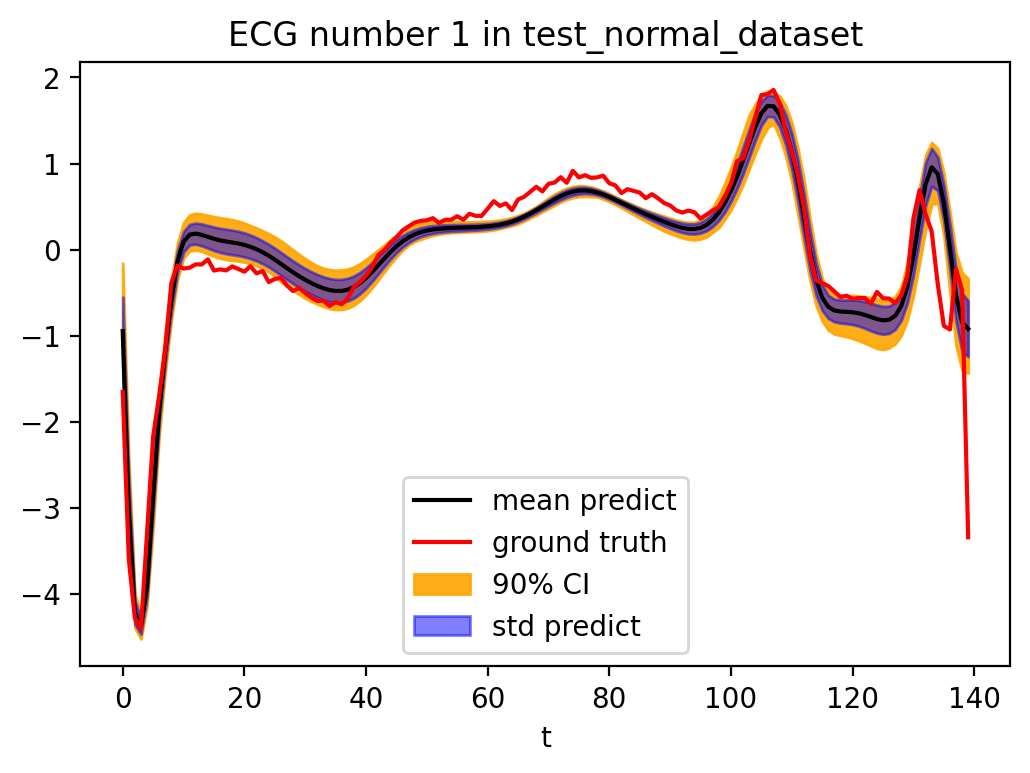

(100, 140, 1)


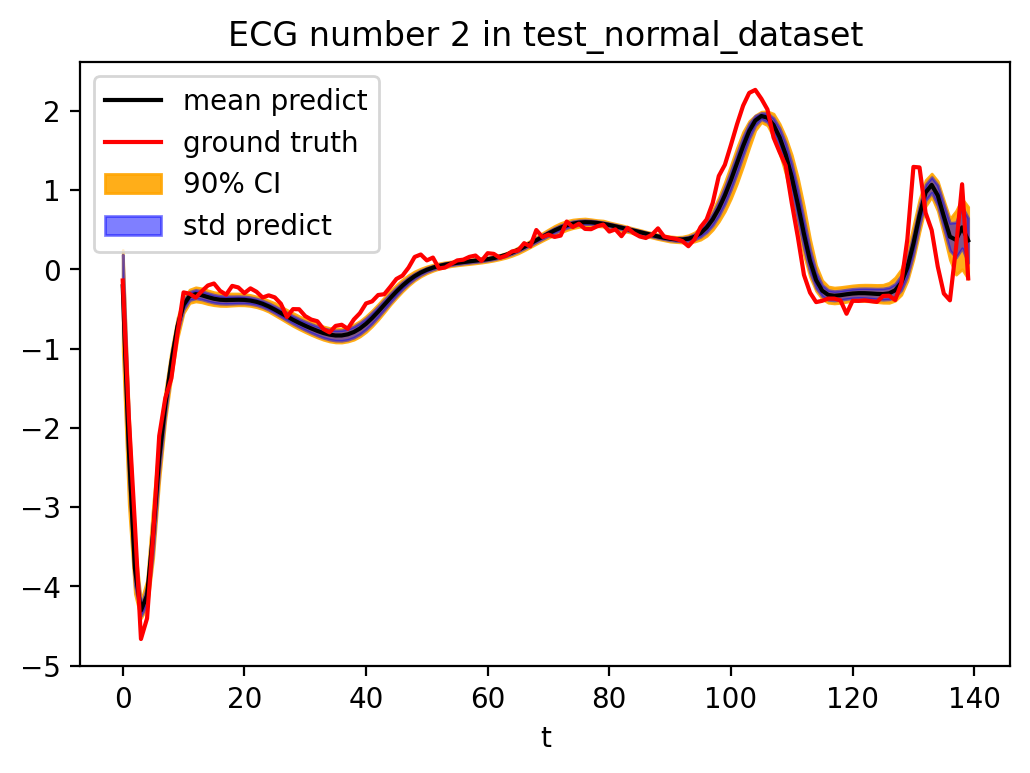

In [173]:
ecg_pred_single(test_normal_dataset,100,0)
ecg_pred_single(test_normal_dataset,100,1)
ecg_pred_single(test_normal_dataset,100,2)


##### Abnormal reconstruction

The model don't fit well anomalous heartbeat!

(100, 140, 1)


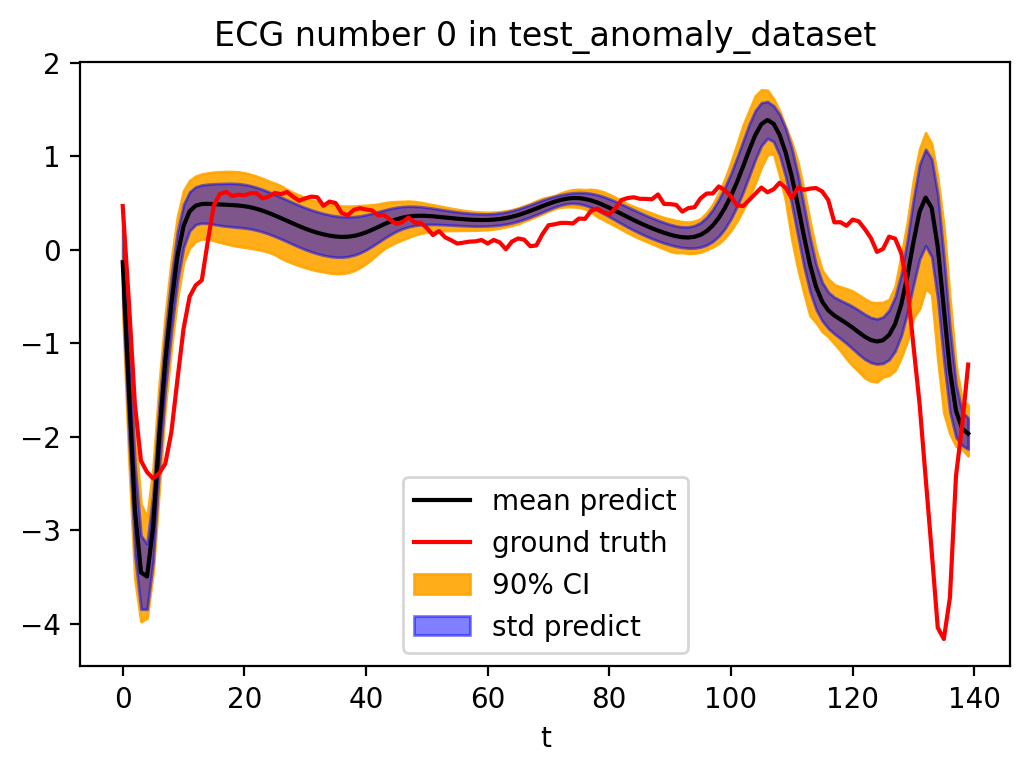

(100, 140, 1)


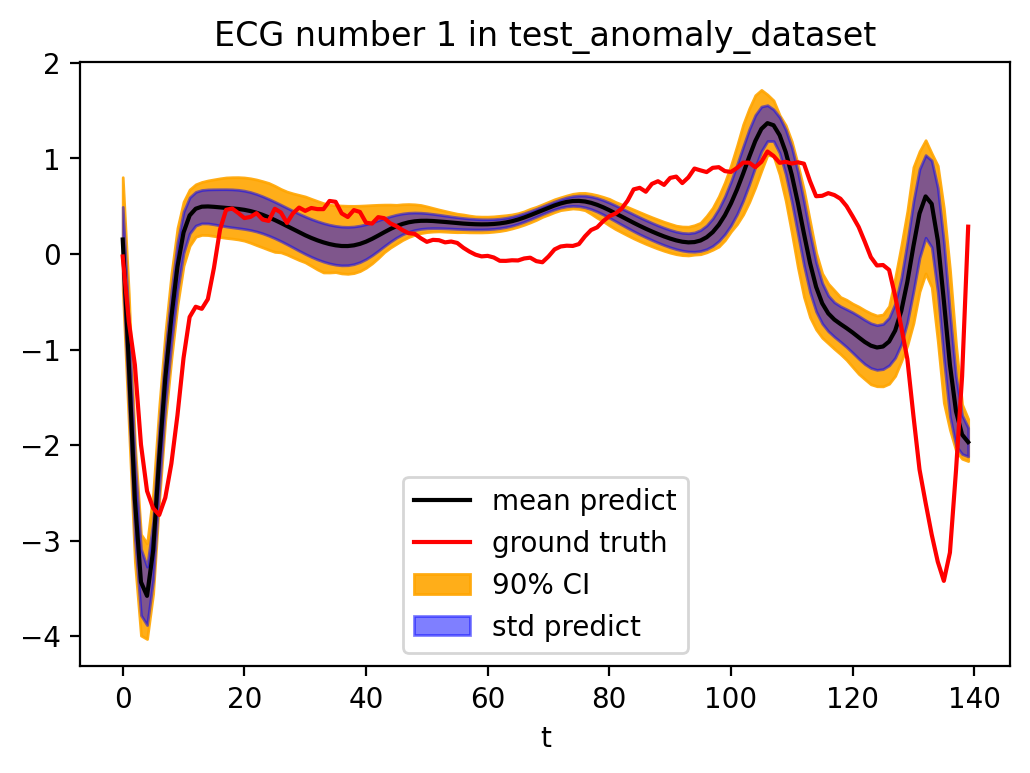

(100, 140, 1)


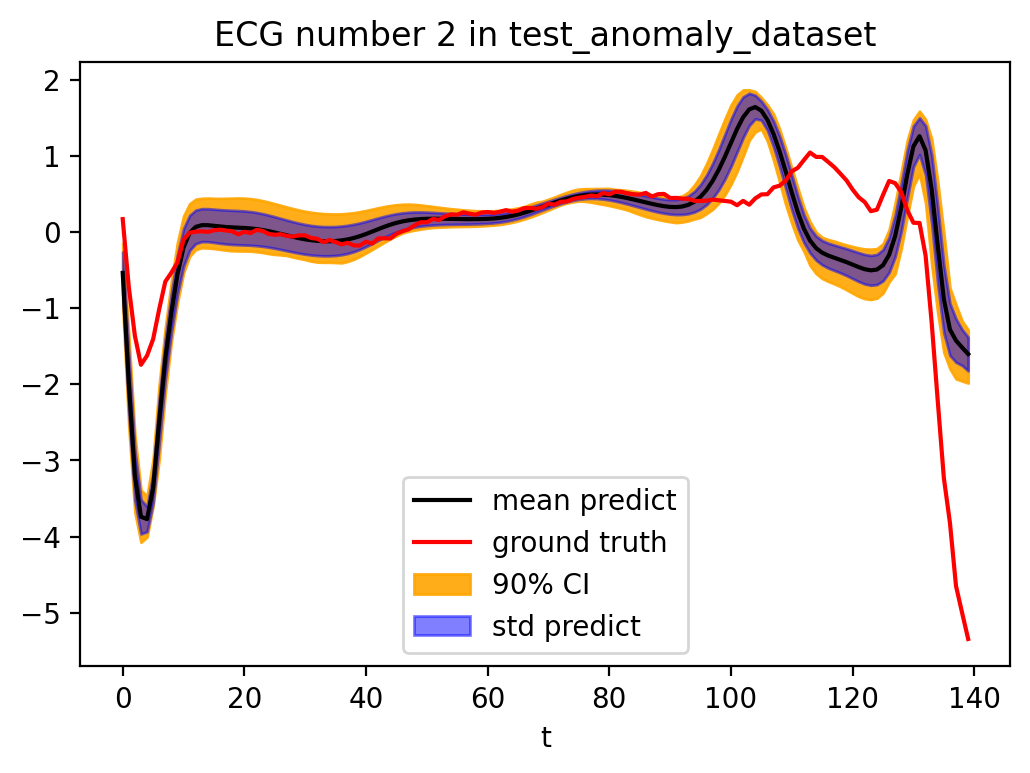

In [174]:
ecg_pred_single(test_anomaly_dataset,100,0)
ecg_pred_single(test_anomaly_dataset,100,1)
ecg_pred_single(test_anomaly_dataset,100,2)

On the reconstruction of anomalous point some parts of the curve have bigger boundaries for 90%CI: those time step are probably the one which are the most different from the normal one and so could lead us to explore those specific points as driving the anomalous labelling.

#### Decision function based on L1 loss

In [47]:
lo=pyroVAE_loss()

In [48]:
df_lo=pd.DataFrame([lo[s] for s in lo.keys()],columns=['L1','Abnormality'])

<AxesSubplot:xlabel='L1', ylabel='Count'>

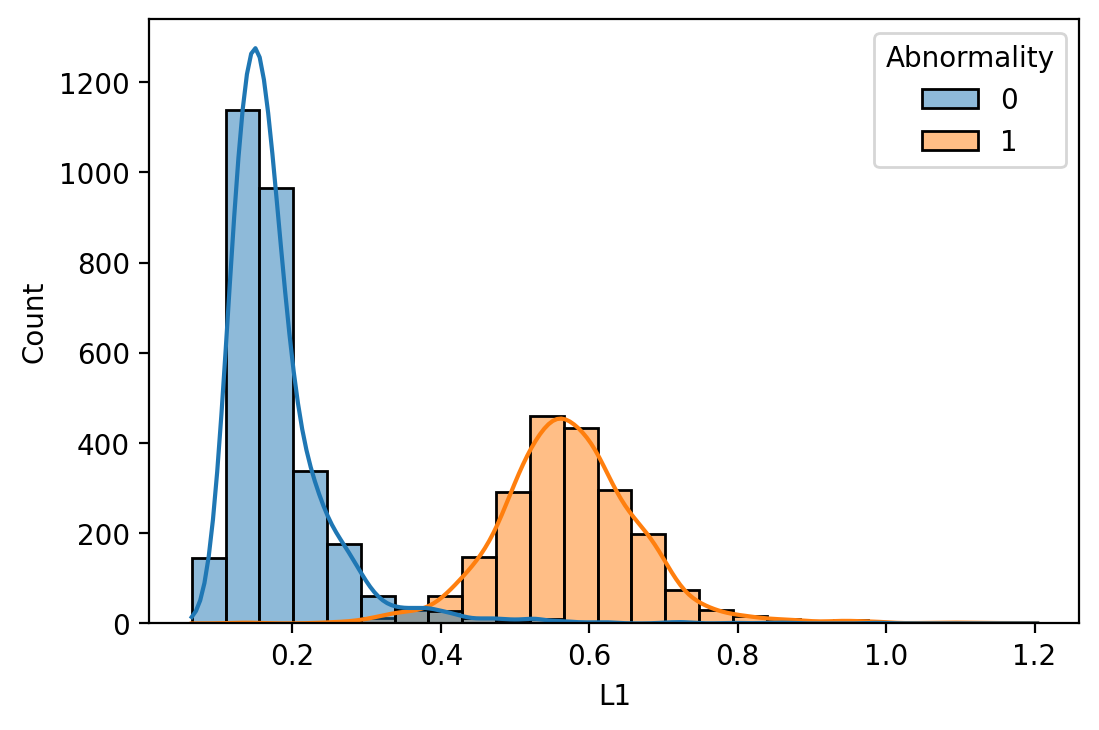

In [49]:
import seaborn as sns
sns.histplot(data=df_lo, x="L1", hue="Abnormality",kde=True)

We can use the fact that the anomalous heartbeat are significatively less well fitted by our model to choose a threshold in our fitting metric (here L1 norm) to decide if we should calssify a heartbeat as normal or anomalous.

We could also directly work with the distances in the latent space (OneSVM). I don't really see the adavantage in that case as one svm still need a choice for some hyperparameter : this choice in our context can not be done by cross validation on for example accuracy since we don't have enought anomalous data for that. So it should be then a choice according to some false positive rate, which already what we will do with the choice of threshold in our L1 loss.

#### Exploring latent space

In the following big circle are the point that exist in our dataset and that we would like to have an for how (which feature change) to move from one to another. Stars are simulated points in the latent space that continuously move the normal point to the anomalous one (int he latent space all those points live in a line serparated by the same increment, that is not the case in the UMAP).

I am not 100% sure how this is usefull or if we could just stick to looking at the final point 90%CI from our model just like before.

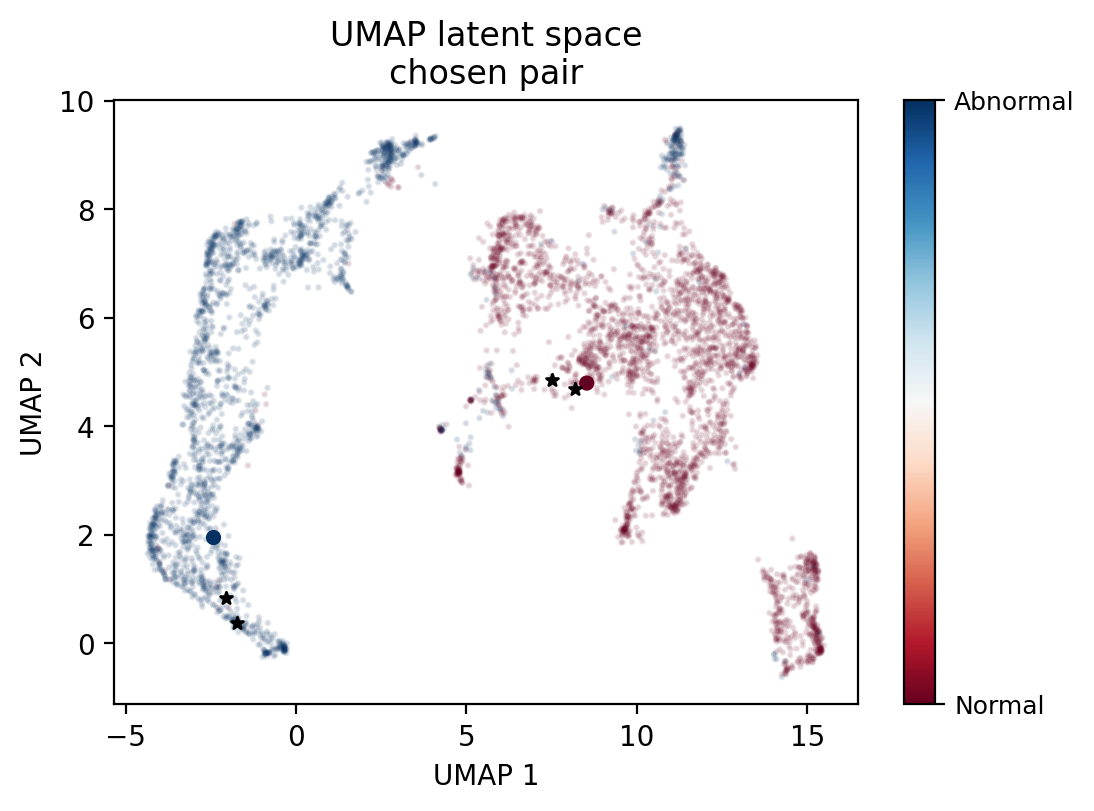

In [328]:
plot_latent_pyro_vea_pair(pyrovae, good_data_loader,100,[10,normal_df.shape[0]+1],_dataset,100,5,14)

The 4 panels with no ground truth are the generated ECG from sampling the stars point above.

<ipython-input-25-1748222b7241>:6: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig,ax=plt.subplots(int(np.ceil(float((interval+1)/3))),3,'all')


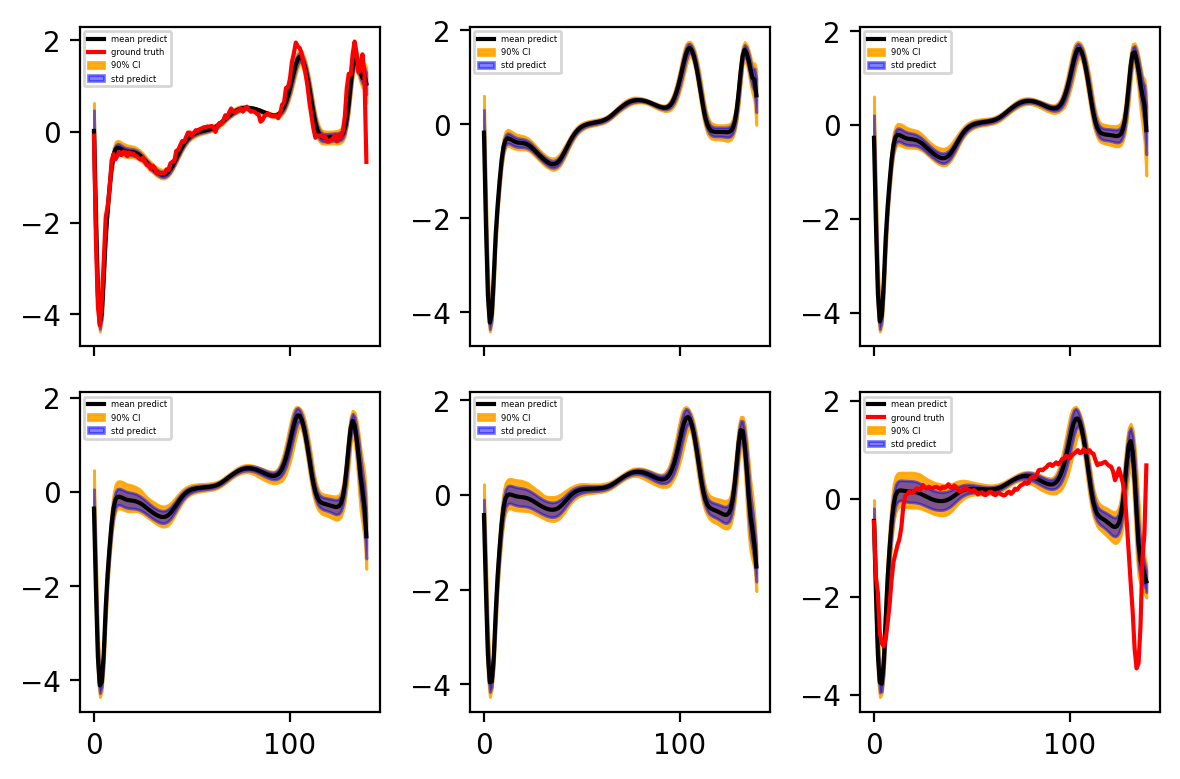

In [26]:
generating_intermediates(_dataset,500,[10,normal_df.shape[0]+1],5)

-[**begining**](#start)